<a href="https://colab.research.google.com/github/thalisreboucas/Python-codes-ML/blob/main/Lab_Guide_06_MindSpore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab Guide 06 - Experimento com MindSpore

Esse experimento tem por objetivo mostrar como usar MindSpore 0.7.0 para realizar uma tarefa coberta pelo **Lab Guide 05** com TensorFlow 2.x: classificação de dígitos manuscritos com o dataset MNIST. 

**Infelizmente, a distribuição de MindSpore ainda não é compatível com o Colaboratory, portanto todas as instruções aqui contidas devem ser executadas em uma máquina com Windows ou Ubuntu Linux.**

**NOTA:** Este Lab Guide é uma adaptação direcionada do [tutorial oficial](https://www.mindspore.cn/tutorial/en/master/quick_start/quick_start.html) da plataforma MindSpore. Este material é disponibilizado para uso exclusivo pelos alunos do curso e não deve ser divulgado sem autorização prévia e expressa.

**IMPORTANTE**: MindSpore faz uso extensivo de tecnologia de compilação JIT (*just in time*) em sua pipeline de processamento, ou seja, o código Python é transformado, otimizado e compilado em tempo de execução pelo motor de grafos subjacente. Consequentemente, os códigos atualmente não podem ser executados separadamente em células do Colab, mas como um arquivo único. Assim, a divisão do exemplo em células aqui apresentada deve ser vista pela perspectiva da didática.

## **[Passo 01]** **Ambiente Python**

Recomendamos fortemente o uso de um gerenciador Python que controle um ambiente de execução separado para a sua experimentação, pois isso cria uma forma segura de lidar com pacotes, dependências e interpretação sem interferir com a configuração do seu sistema.

No caso, utilizaremos [Miniconda](https://docs.conda.io/en/latest/miniconda.html) devido à sua simplicidade: siga as suas [instruções de instalação](https://docs.conda.io/en/latest/miniconda.html#installing) antes de prosseguir.



#### **Criando um ambiente Conda com Python 3.7.5**
Abra um terminal, digite o seguinte comando e confirme:

In [ ]:
conda create -n hcia-ai python=3.7.5

#### **Ativando o Ambiente**
O comando anterior criou um ambiente chamado **hcia-ai**, que pode ser ativado da seguinte maneira:

In [ ]:
conda activate hcia-ai

A partir de então, os seus comandos Python e demais terão efeito sobre o ambiente configurado. No Linux, você deverá visualizar um prefixo **\(hcia-ai\)** no terminal, indicando que este ambiente está ativo. Proceda para instalação do MindSpore.

## **[Passo 02]** **Instalando MindSpore 0.7.0**
A seguir descrevemos o processo de instalação para as plataformas Windows e Ubuntu Linux a partir de arquivos no formato Wheel (WHL), que é o padrão usado a distribuição de pacotes Python.

Cobriremos as opções mais comuns, portanto o leitor interessado em outras versões da API, virtualização e demais "sabores" do MindSpore deve visitar o [site oficial](https://www.mindspore.cn/install/en) para maiores detalhes.

A instalação é simples e é feita via terminal no seu sistema operacional.

### Instalação via **pip** para Windows.

In [ ]:
pip install https://ms-release.obs.cn-north-4.myhuaweicloud.com/0.7.0-beta/MindSpore/cpu/windows_x64/mindspore-0.7.0-cp37-cp37m-win_amd64.whl

### Instalação via **pip** para Unbuntu Linux

In [ ]:
pip install https://ms-release.obs.cn-north-4.myhuaweicloud.com/0.7.0-beta/MindSpore/cpu/ubuntu_x86/mindspore-0.7.0-cp37-cp37m-linux_x86_64.whl

### **Avançado:** MindSpore para Ubuntu com suporte a GPU via CUDA 10.1

Essa versão depende de uma configuração prévia dos drivers CUDA e que está a cargo do próprio usuário, sob seu *próprio risco e resposabilidade*. Recomendamos usar o ambiente.



In [ ]:
pip install https://ms-release.obs.cn-north-4.myhuaweicloud.com/0.7.0-beta/MindSpore/gpu/ubuntu_x86/cuda-10.1/mindspore_gpu-0.7.0-cp37-cp37m-linux_x86_64.whl

### **Verificando a Instalação**
No seu ambiente, use o seguinte comando para checar qual a versão do Python está sendo executada. Se não for a **3.7.5**, você provavelmente não está no ambiente correto! Ative o ambiente de acordo com as [instruções anteriores](#scrollTo=nL-GiiYwmzef&line=5&uniqifier=1)


In [ ]:
python --version

Executemos o seguinte exemplo para verificar o funcionamento do MindSpore:

In [ ]:
# usaremos NumPy para controle fino dos
import numpy as np
#
import mindspore.context as context
import mindspore.nn as nn
from mindspore import Tensor
from mindspore.ops import operations as P

# configura execução em Graph Mode do MindSpore
context.set_context(mode=context.GRAPH_MODE, device_target="CPU")

# define uma célula de multiplicação
class Mul(nn.Cell):
    def __init__(self):
        super(Mul, self).__init__()
        self.mul = P.Mul()

    def construct(self, x, y):
        return self.mul(x, y)

# cria dois tensores
x = Tensor(np.array([1.0, 2.0, 3.0]).astype(np.float32))
y = Tensor(np.array([4.0, 5.0, 6.0]).astype(np.float32))

# opera os tensores e exibe o resultado
mul = Mul()
print( mul(x, y) )

### **Organização do Dataset MNIST**
Usaremos os dados baixados a partir do site http://yann.lecun.com/exdb/mnist/, organizados da seguinte maneira:
<pre>
 MNIST_Data
    ├─test
    │      t10k-images.idx3-ubyte
    │      t10k-labels.idx1-ubyte
    │
    └─train
            train-images.idx3-ubyte
            train-labels.idx1-ubyte
</pre>

Utilizaremos as facilidades de download e descompactação incluídas nos script que veremos a seguir.

## **[Passo 03] Executando o Experimento**

Este experimento foi projetado para **MindSpore 0.7.0**, configurado de acordo com as etapas anteriores. Certifique-se de que seu ambiente funciona antes de continuar.

### **4.1 Carregando as Dependências**

In [ ]:
# lidar com arquivos, path, etc
import os
# requisições HTTP
import urllib.request
from urllib.parse import urlparse
# compressão/descompressão
import gzip
# lida com argumentos de linha de comando
import argparse

# ================================================
# APIs MindSpore
# ================================================

import mindspore.dataset as ds
import mindspore.nn as nn
from mindspore import context

from mindspore.nn.metrics import Accuracy
from mindspore.nn.loss import SoftmaxCrossEntropyWithLogits

from mindspore.common import dtype as mstype
from mindspore.common.initializer import TruncatedNormal

from mindspore.train import Model
from mindspore.train.serialization import load_checkpoint, load_param_into_net
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor

import mindspore.dataset.transforms.vision.c_transforms as CV
import mindspore.dataset.transforms.c_transforms as C
from mindspore.dataset.transforms.vision import Inter





### **4.2 Configurando o Dataset**

As funções utilitárias **unzipfile()** e **download_dataset()** fogem ao escopo desse exercício. Desse modo, não serão tratadas em profundidade.

In [ ]:
def unzipfile(gzip_path):
    """ descompactação de arquivos no formato gzip
    Args:
        gzip_path: caminho para o arquivo a ser descompactado
    """
    open_file = open(gzip_path.replace('.gz',''), 'wb')
    gz_file = gzip.GzipFile(gzip_path)
    open_file.write(gz_file.read())
    gz_file.close()


def download_dataset():
    """Download a partir de http://yann.lecun.com/exdb/mnist/."""
    train_path = "./MNIST_Data/train/"
    test_path = "./MNIST_Data/test/"
    train_path_check = os.path.exists(train_path)
    test_path_check = os.path.exists(test_path)

    if train_path_check == False and test_path_check ==False:
        print("******Downloading the MNIST dataset******")
        os.makedirs(train_path)
        os.makedirs(test_path)
    train_url = {"http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz",
                 "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz"
                }
    test_url = {"http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz",
                "http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz"
               }

    for url in train_url:
        url_parse = urlparse(url)
        # separa o nome do arquivo na URL
        file_name = os.path.join(train_path,url_parse.path.split('/')[-1])
        if not os.path.exists(file_name.replace('.gz','')):
            file = urllib.request.urlretrieve(url, file_name)
            unzipfile(file_name)
            os.remove(file_name)
    
    for url in test_url:
        url_parse = urlparse(url)
        # separa o nome do arquivo na URL
        file_name = os.path.join(test_path,url_parse.path.split('/')[-1])
        if not os.path.exists(file_name.replace('.gz','')):
            file = urllib.request.urlretrieve(url, file_name)
            unzipfile(file_name)
            os.remove(file_name)

Agora trataremos da criação do Dataset. Uma das diferenças entre TensorFlow e MindSpore está no tratamento granular de como os dados são processados, pois isso afeta as aplicações.

Assim, as imagens passarão por uma pipeline de operações antes que sejam submetidas aos processos de treinamento e validação.

In [ ]:
def create_dataset(data_path, batch_size=32, repeat_size=1,
                   num_parallel_workers=1):
    """ Cria o dataset MNIST, seja para treino, seja para teste
    Args:
        data_path: Diretório onde está o dataset. Ex: MNIST_Data
        batch_size: Tamanho de cada lote no dataset
        repeat_size: Número de réplicas desejado, para cada amostra
        num_parallel_workers: Número workers, para explorar processamento paralelo
    """
    # cria uma instância padrão do Dataset
    mnist_ds = ds.MnistDataset(data_path)

    # dimensões das imagens
    resize_height, resize_width = 32, 32
    # fator de escala nos pixels
    rescale = 1.0 / 255.0
    # deslocamento: nulo
    shift = 0.0
    # escala e deslocamentos usados na normalização
    rescale_nml = 1 / 0.3081
    shift_nml = -1 * 0.1307 / 0.3081

    # 1) define as operações na pipeline de mapeamento
    # - as imagens originais são 28x28, ilustra redimensionamento para 32x32 usando o filtro bilinear para ampliar os pixels
    # - após isso as imagens são normalizadas para uma média e escala
    # - depois disso os dados passam por outro ajuste semelhante
    # - o shape de entrada de cada imagem é alterado, indo de (altura,largura,canal) para (canal, altura,largura),
    #   ou seja, resulta em imagens nas quais o buffer de cada canal está separado em uma região contígua da memória
    # - finalmente, converte o identificador das classes em números inteiros
    resize_op = CV.Resize((resize_height, resize_width), interpolation=Inter.LINEAR)
    rescale_nml_op = CV.Rescale(rescale_nml, shift_nml)
    rescale_op = CV.Rescale(rescale, shift)
    hwc2chw_op = CV.HWC2CHW()
    type_cast_op = C.TypeCast(mstype.int32)

    # 2) aplica cada operação de mapeamento definida no passo anterior
    mnist_ds = mnist_ds.map(input_columns="label", operations=type_cast_op, num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(input_columns="image", operations=resize_op, num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(input_columns="image", operations=rescale_op, num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(input_columns="image", operations=rescale_nml_op, num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(input_columns="image", operations=hwc2chw_op, num_parallel_workers=num_parallel_workers)

    # 3) operações sobre o próprio dataset (vide DatasetOps)
    #   - embaralhamento, partição em lotes e repetição de amostras
    buffer_size = 10000
    mnist_ds = mnist_ds.shuffle(buffer_size=buffer_size)
    mnist_ds = mnist_ds.batch(batch_size, drop_remainder=True)
    mnist_ds = mnist_ds.repeat(repeat_size)

    return mnist_ds

### **4.3 Definindo a Arquitetura LeNet5 com MindSpore**

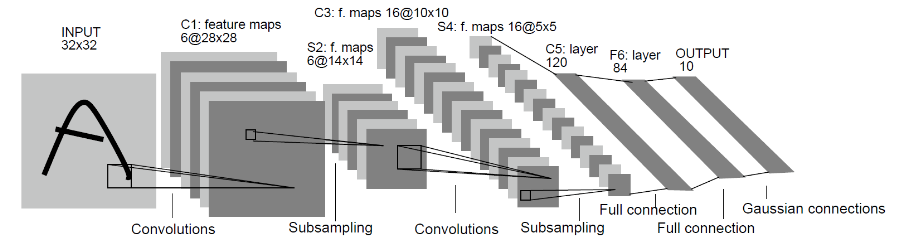
http://yann.lecun.com/exdb/lenet/

Defiamos algumas funções utilitárias:
 - criação de uma camada de convolução inicializada como [mindspore.common.initializer.TruncatedNormal](https://www.mindspore.cn/api/en/master/api/python/mindspore/mindspore.common.initializer.html#mindspore.common.initializer.TruncatedNormal), uma distribuição normal truncada.
 - criação de uma camada densa cujos pesos e biases dos neurônios também são inicializados via **TruncatedNormal**;

In [ ]:
def conv(in_channels, out_channels, kernel_size, stride=1, padding=0):
    """Convolução com pesos inicializados por TruncatedNormal()."""
    weight = weight_variable()
    return nn.Conv2d(in_channels, out_channels,
                     kernel_size=kernel_size, stride=stride, padding=padding,
                     weight_init=weight, has_bias=False, pad_mode="valid")


def fc_with_initialize(input_channels, out_channels):
    """Convolução com pesos inicializados por TruncatedNormal()"""
    weight = weight_variable()
    bias = weight_variable()
    return nn.Dense(input_channels, out_channels, weight, bias)


def weight_variable():
    """Cria um inicializador de pesos do tipo """
    return TruncatedNormal(0.02)

Agora a instanciação da camada LeNet como especialização do tipo [mindspore.nn.Cell](https://www.mindspore.cn/api/en/master/api/python/mindspore/mindspore.nn.html#mindspore.nn.Cell), o tipo básico usado para todas as redes neurais no MindSpore. Note que as camadas são muito semelhantes àquelas usadas no Lab Guide anterior, que versava sobre TensorFlow.

Veja que o construtor (método *__init__()*) define as camadas, quanto o método *construct()* conecta esses elementos, formando o grafo que representa a rede neural.

In [ ]:
class LeNet5(nn.Cell):
    """cria uma rede LeNet5, tal como pode ser visto no
       site: http://yann.lecun.com/exdb/lenet/
    """
    # definição dos operadores necessários à rede
    def __init__(self, num_class=10, num_channel=1):
        super(LeNet5, self).__init__()

        self.conv1 = conv(1, 6, 5)
        self.conv2 = conv(6, 16, 5)
        self.fc1 = fc_with_initialize(16 * 5 * 5, 120)
        self.fc2 = fc_with_initialize(120, 84)
        self.fc3 = fc_with_initialize(84, 10)
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

    # conecta os operadores, construindo a rede
    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

### **4.4 Configurando um Modelo**
Para treinar uma rede neural, é preciso utilizar um modelo, que é instância da classe [mindspore.Model](https://www.mindspore.cn/api/en/master/api/python/mindspore/mindspore.html#mindspore.Model), a fim de configurar o otimizador, a política de salvamento de checkpoints, a função de perda e as métricas de desempenho monitoradas.

Note-se que a função de perda escolhida é [mindspore.nn.SoftmaxCrossEntropyWithLogits](https://www.mindspore.cn/api/en/master/api/python/mindspore/mindspore.nn.html#mindspore.nn.SoftmaxCrossEntropyWithLogits), pois as classes são mutuamente exclusivas para cada imagem.

**NOTA:** esse trecho de código deve ser desconsiderado na execução do exemplo compelto

In [ ]:
# cria a rede
network = LeNet5()

# 1) otimizador
net_opt = nn.Momentum(network.trainable_params(), lr, momentum)
# 2) política de geração de checkpoints e callback
config_ck = CheckpointConfig(save_checkpoint_steps=1875, keep_checkpoint_max=10)
ckpoint_cb = ModelCheckpoint(prefix="checkpoint_lenet", config=config_ck)
# 3) função de perda: softmax crossentropy com logits
net_loss = SoftmaxCrossEntropyWithLogits(is_grad=False, sparse=True, reduction='mean')

# 4) Instancia um modelo "treinável"
model = Model(network, net_loss, net_opt, metrics={"Accuracy": Accuracy()})

### **4.5 Treinando o Modelo**
Seguindo a ideia de modularização, definamos uma função:
 - *args*, argumento geral, não usado ainda;
 - *model*, modelo já criado e configurado;
 - *epoch_size*, quantidade de épocas no treinamento;
 - *mnist_path*, caminho para o diretório do dataset;
 - *repeat_size*, número de réplicas de cada amostra no dataset;
 - *ckpoint_cb*, função de callback para tratar eventos de checkpoint, i.e., gerar cópias de segurança do modelo quando necessário;
 - *sink_mode*, indica onde o dataset será armazenado para processamento.

O dataset é configurado para usar batches com 32 amostras cada, extraídas do conjunto de treinamento. Além disso, um callback [LossMonitor](https://www.mindspore.cn/api/en/master/api/python/mindspore/mindspore.train.html?highlight=lossmonitor#mindspore.train.callback.LossMonitor) para exibir o progresso do treinamento a cada passo/batch

In [ ]:
def train_net(args, model, epoch_size, mnist_path, repeat_size, ckpoint_cb, sink_mode):
    """Define como treinar um modelo recebido como argumento """
    print("============== Iniciando o Treinamento ==============")
    # configuração do dataset
    ds_train = create_dataset(os.path.join(mnist_path, "train"), 32, repeat_size)
    # dispara o treinamento, que gerará um checkpoint "checkpoint_lenet_1-1_1875.ckpt"
    model.train(epoch_size, ds_train, callbacks=[ckpoint_cb, LossMonitor()], dataset_sink_mode=sink_mode)

### **4.5 Avaliando o Modelo Treinado**
A avaliação é simples, partindo de um checkpoint treinado:
 - Os pesos são carregados de um arquivo e restaurados como o modelo;
 - Um dataset deve ser configurado, dessa vez usando os dados de teste;
 - a avaliação é feita usando o método **eval()** do modelo, o qual retorna um dicionário com os valores das métricas de desempenho usadas. No caso, apenas a acurácia está sendo usada ('Accuracy').

In [ ]:
def test_net(args, network, model, mnist_path):
    """Dispara a avaliação de uma rede já treinada."""
    
    print("============== Starting Testing ==============")
    # carrega um checkpoint do modelo
    param_dict = load_checkpoint("checkpoint_lenet-1_1875.ckpt")
    # restaura a rede a partir do checkpoint
    load_param_into_net(network, param_dict)
    
    # carregamento dos dados de avaliação
    ds_eval = create_dataset(os.path.join(mnist_path, "test"))
    
    # avaliação do modelo
    res = model.eval(ds_eval, dataset_sink_mode=False)
    print(f"============== Accuracy:{ res['Accuracy'] } ==============")


### **4.6 Invocando como Aplicação Python**
Em primeiro lugar, é configurado o ambiente de execução, usando a API [mindspore.context](https://www.mindspore.cn/api/en/master/api/python/mindspore/mindspore.context.html) para:
 - Execução preferencial sobre *CPU* (por padrão); e
 - Utilização do **graph mode**, que faz com que um grafo seja compilado a partir de uma representação intermediária (IR) para execução.

Após isso são configurados os parâmetros de otimização do modelo, que passa a ser treinado e depois usado para avaliação sobre o subconjunto de imagens de testes do dataset MNIST.

In [ ]:
if __name__ == "__main__":
    # código legado, lida com opções de linha de comando
    parser = argparse.ArgumentParser(description='MindSpore LeNet Example')
    parser.add_argument('--device_target', type=str,
                        default="CPU",
                        choices=['Ascend', 'GPU', 'CPU'],
                        help='device where the code will be implemented (default: CPU)')
    args = parser.parse_args()

    # ===============================================
    # inicializa o contexto de execução como o graph mode
    # ===============================================
    context.set_context(mode=context.GRAPH_MODE, device_target=args.device_target)

    # download do dataset MNIST
    download_dataset()

    # ===============================================
    # configuração de parâmetros
    # ===============================================
    dataset_sink_mode = not args.device_target == "CPU"
    lr = 0.01       # learning rate
    momentum = 0.9  # momentum
    epoch_size = 1  # usa apenas 1 época
    mnist_path = "./MNIST_Data"
    repeat_size = 1
    # ===================================
    # criação da rede
    network = LeNet5()
    
    # ===================================
    # configuração do modelo
    
    # a) otimizador
    net_opt = nn.Momentum(network.trainable_params(), lr, momentum)
    # b) política de geração de checkpoints, usada para configurar um callbak
    config_ck = CheckpointConfig(save_checkpoint_steps=1875, keep_checkpoint_max=10)
    ckpoint_cb = ModelCheckpoint(prefix="checkpoint_lenet", config=config_ck)
    # c) função de perda:
    net_loss = SoftmaxCrossEntropyWithLogits(is_grad=False, sparse=True, reduction='mean')
    # group layers into an object with training and evaluation features
    model = Model(network, net_loss, net_opt, metrics={"Accuracy": Accuracy()})

    # ===================================
    # treinamento
    train_net(args, model, epoch_size, mnist_path, repeat_size, ckpoint_cb, dataset_sink_mode)

    # ===================================
    # avaliação do modelo
    test_net(args, network, model, mnist_path)

Executando todos os exemplos em um único arquivo via linha de comando, teremos uma saída semelhante a esta:
<pre>
******Downloading the MNIST dataset******
============== Starting Training ==============
epoch: 1 step: 1, loss is 2.3048673
epoch: 1 step: 2, loss is 2.302471
epoch: 1 step: 3, loss is 2.306556
epoch: 1 step: 4, loss is 2.3026621
 ...
epoch: 1 step: 1870, loss is 0.12739936
epoch: 1 step: 1871, loss is 0.21252097
epoch: 1 step: 1872, loss is 0.06654224
epoch: 1 step: 1873, loss is 0.12267333
epoch: 1 step: 1874, loss is 0.072500005
epoch: 1 step: 1875, loss is 0.20904273
============== Starting Testing ==============
============== Accuracy:{'Accuracy': 0.9595352564102564} ==============
</pre>
